In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas, json
from scipy.interpolate import interp1d
import corner
def gen_samples_using_invcdf(func, minimum, maximum, nsamples):
    """
    Implements inverse cdf sampling for a power function.
    func: pdf to draw samples from
    minimum: minimum value
    maximum: maximum value    
    """
    xarr = np.linspace(minimum, maximum, 50000)
    yarr = func(xarr)
    cumulative_sum = np.cumsum(yarr)
    cumulative_sum *= 1 / cumulative_sum[-1]
    
    interped_inverse_cdf = interp1d(cumulative_sum, xarr)    
    uniform_samples = np.random.uniform(min(cumulative_sum), 1, nsamples)
    
    return interped_inverse_cdf(uniform_samples)

In [2]:
f = open('/home/aditya/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_result.json')
data = json.load(f)
samples = data["posterior"]["content"]

samples = pandas.DataFrame.from_dict(samples)
samples

,alpha,beta,mmax,mmin,lam,mpp,sigpp,delta_m,mu_chi,sigma_chi,...,lamb,amax,log_likelihood,log_prior,selection,pdet_n_effective,surveyed_hypervolume,log_10_rate,rate,min_event_n_effective
0,2.116671,0.645405,84.257180,3.858558,0.075468,30.270897,8.346910,3.511792,0.262951,0.033104,...,-1.007767,1.0,86.740514,-20.167742,0.006983,6630.971573,300.455132,1.475926,29.917560,205.407820
1,2.357356,0.504086,78.325899,5.301450,0.123904,38.688342,4.317169,2.576325,0.247116,0.028849,...,-2.460752,1.0,88.476899,-20.167742,0.016273,3772.629171,107.519753,1.521225,33.206611,84.680631
2,2.763145,-1.038759,92.335648,4.512187,0.136947,26.322204,9.283129,3.411572,0.201743,0.024835,...,4.922529,1.0,89.160301,-20.167742,0.000089,4852.535111,69321.160923,1.075940,11.910773,107.429424
3,2.975530,1.204292,81.253295,5.193624,0.095203,40.661528,6.232922,4.752846,0.223713,0.024432,...,-1.466976,1.0,89.577067,-20.167742,0.010964,4340.422763,213.598090,1.485615,30.592485,89.268950
4,2.336330,0.888358,83.282458,3.218458,0.150673,27.806907,6.098497,5.846578,0.240640,0.019683,...,1.572624,1.0,89.923126,-20.167742,0.001794,5813.075241,2629.581289,1.171681,14.848441,80.848769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11464,3.417291,0.301697,85.168951,4.798439,0.035291,33.889739,2.350728,5.505413,0.230583,0.020566,...,3.264948,1.0,108.115543,-20.167742,0.000339,2972.807715,13097.278496,1.214318,16.380142,71.881363
11465,3.328885,1.642387,79.491399,4.931802,0.034236,34.720684,2.136944,5.327197,0.254585,0.032604,...,2.109967,1.0,108.120336,-20.167742,0.000872,3152.917529,4322.664396,1.369043,23.390707,72.814645
11466,3.328885,1.642387,79.491399,4.931802,0.034236,34.720684,2.136944,5.327197,0.254585,0.032604,...,2.109967,1.0,108.120336,-20.167742,0.000872,3152.917529,4322.664396,1.288162,19.416100,72.814645
11467,3.548725,0.760204,83.140164,4.815572,0.019037,34.467261,1.866748,5.453627,0.235676,0.024758,...,3.431551,1.0,108.206956,-20.167742,0.000256,3214.364467,15429.210409,1.259669,18.183135,76.580270


The description of the samples is given in eq B4 of https://arxiv.org/pdf/2111.03634.pdf. The priors can be found in Table VI.

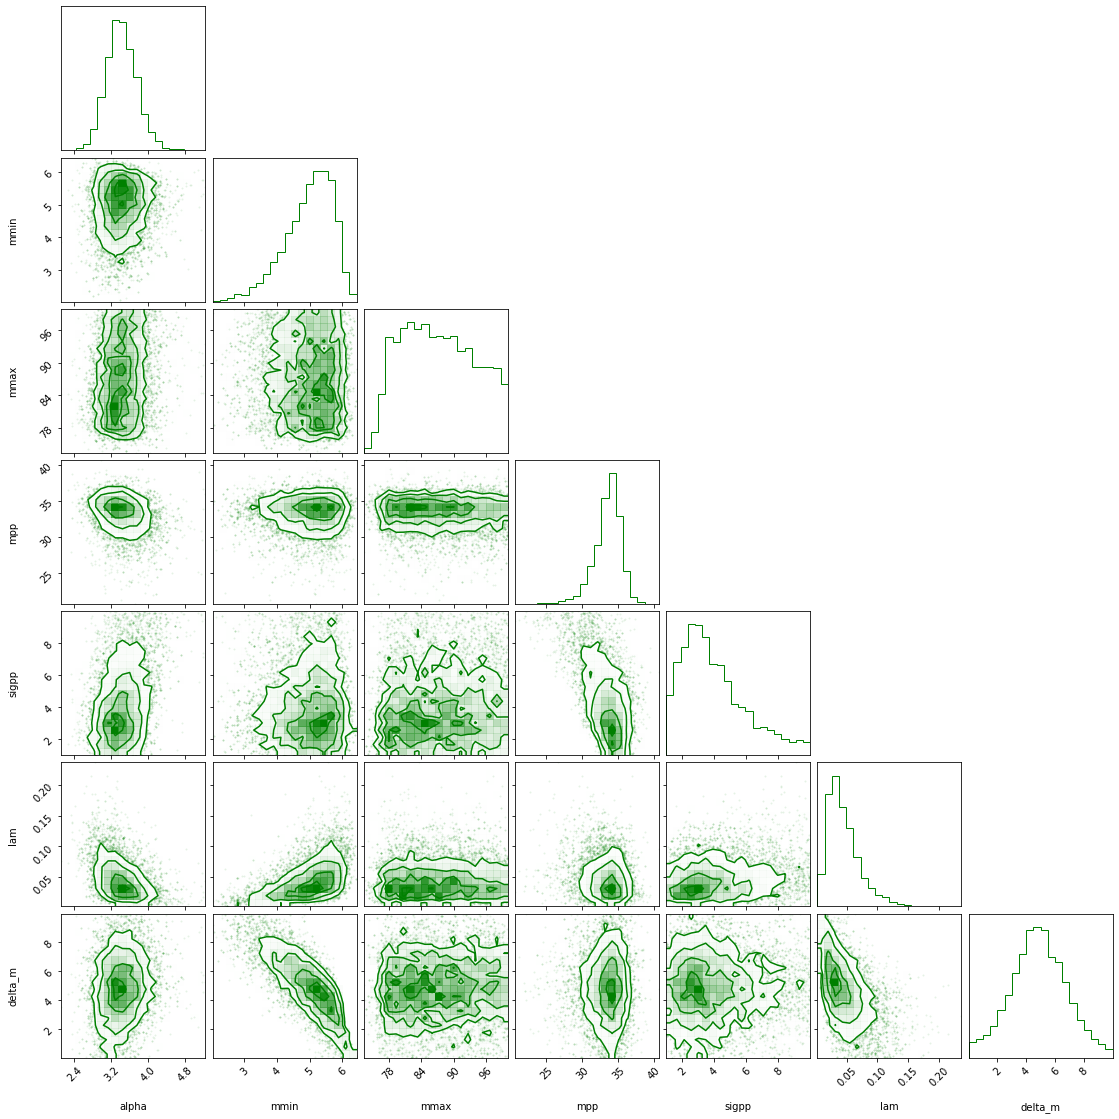

In [10]:
%matplotlib inline

variables_to_plot = ["alpha", "mmin", "mmax", "mpp", "sigpp", "lam", "delta_m"]
data_to_plot = np.column_stack([samples[var] for var in variables_to_plot])
fig = corner.corner(data_to_plot, labels=variables_to_plot, color="green")

plt.show()

In [4]:
def power_law_normalized(masses, alpha, mmin, mmax,):
    normalization = mmin ** (1 - alpha) - mmax ** (1 - alpha)
    normalization *= 1 / ( alpha - 1)
    
    return masses ** (-alpha) / normalization

def gaussian_normalized(masses, mpp, sigpp):
    gaussian = np.exp(- (masses - mpp) ** 2 / sigpp ** 2) 
    gaussian *= 1/np.sqrt(2 * np.pi * sigpp ** 2) 
    return gaussian

def pl_plus_peak(masses, alpha, mmin, mmax, mpp, sigpp, lam, delta_m):
    res = (1 - lam) * power_law_normalized(masses, alpha, mmin, mmax)
    res += lam * gaussian_normalized(masses, mpp, sigpp)
    kernel = np.zeros_like(masses)
    kernel[masses < mmin] = 0
    
    idx = np.logical_and(mmin < masses, masses < mmin + delta_m)
    kernel[idx] = 1/np.exp(
        delta_m/masses[idx] + delta_m / (masses[idx] - delta_m)
    )
    kernel[masses >=  mmin + delta_m] = 1

    return kernel * res

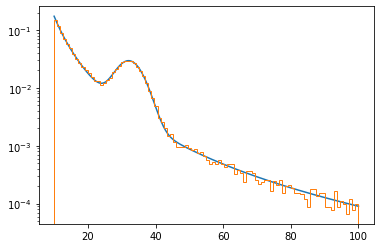

In [14]:
params = ["alpha", "mmin", "mmax", "mpp", "sigpp", "lam", "delta_m"]
param_dict = dict()
sample = samples.iloc[np.random.choice(len(samples))]
for param in params:
    param_dict[param] = sample[param]
    m_arr = np.linspace(10, 100, 1000)
model = pl_plus_peak(m_arr,**param_dict)
model /= np.sum(model) * (np.diff(m_arr)[0])
plt.semilogy(m_arr, model)

plpeak = lambda masses: pl_plus_peak(masses, **param_dict)
hist_samples = gen_samples_using_invcdf(plpeak, 10, 100, 100000)
plt.hist(hist_samples, density=True, histtype="step", bins=100)
plt.show()

(0.0001, 0.4353515580318553)

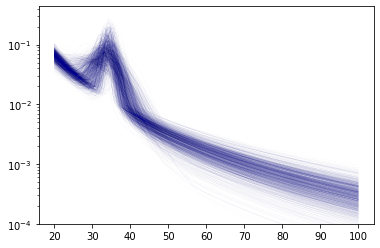

In [15]:
max_log_likelihood = np.amax(samples["log_likelihood"])
min_log_likelihood = np.amin(samples["log_likelihood"])
diff = max_log_likelihood - min_log_likelihood
for i in range(1000):
    sample = samples.iloc[np.random.choice(len(samples))]
    params = ["alpha", "mmin", "mmax", "mpp", "sigpp", "lam", "delta_m"]
    param_dict = dict()
    lnL = sample["log_likelihood"]
    for param in params:
        param_dict[param] = sample[param]
    m_arr = np.linspace(20, 100, 1000)
    model = pl_plus_peak(m_arr,**param_dict)
    model /= np.sum(model) * (np.diff(m_arr)[0])
    alpha= (lnL - min_log_likelihood)/(diff)
    plt.semilogy(m_arr, model, alpha=alpha, color="darkblue", lw=0.02)
plt.ylim(ymin=1e-4)